Establishing a connection with sqlite database

In [1]:
# import pandas as pd
# import sqlite3

In [2]:
# # def function to create connection to db
# def create_connection(db_file):
#     """
#     create a database connection to the SQLite database specified by db_file
#     :param df_file: database file
#     :return: Connection object or None
#     """
#     conn = None
#     try: 
#         conn = sqlite3.connect(db_file)
#         return conn
#     except 'Error' as e:
#         print(e)
        
#     return conn

In [3]:
# # create connection to db
# conn = create_connection('s3://sagemaker-studio-520298385440-7in8n1t299/dublinbus.db')

In [4]:
# # initialise query
# query = """
# SELECT leavetimes.*
# FROM leavetimes 
# WHERE TRIPID in  
#     (SELECT TRIPID
#     FROM trips
#     WHERE LINEID = '46A');
# """

In [5]:
# # execute query and read into dataframe
# query_df = pd.read_sql(query, conn)

# 1. Model Preperation

In [6]:
# import boto3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm

# from sagemaker import get_execution_role
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Connecting to s3
# role = get_execution_role()
# bucket='sagemaker-studio-520298385440-7in8n1t299'
# data_key = 'route_46a.feather'
# data_location = 's3://{}/{}'.format(bucket, data_key)

In [7]:
# Loading file
df = pd.read_feather('route_46a-Copy1.feather')

## 1.1. Reviewing, splitting dataset into 7:3 for training and testing.

In [8]:
df.head(5)

,level_0,index,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,ACTUALTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY
0,969,43824,2018-01-01,Monday,January,5955567,15,334,2868381,37920,37840,37920,37840,0,-48195,-48394,1,1
1,970,43825,2018-01-01,Monday,January,5955567,16,406,2868381,38117,37913,38117,37922,9,197,73,1,1
2,971,43826,2018-01-01,Monday,January,5955567,17,747,2868381,38226,37983,38226,37983,0,109,61,1,1
3,972,43827,2018-01-01,Monday,January,5955567,18,842,2868381,38326,38047,38326,38047,0,100,64,1,1
4,973,43828,2018-01-01,Monday,January,5955567,19,845,2868381,38391,38079,38391,38079,0,65,32,1,1


In [9]:
df.tail(5)

,level_0,index,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,ACTUALTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY
4347782,4346354,116750045,2018-12-31,Monday,December,8590439,5,811,2868385,69850,69740,69850,69801,61,47,59,0,1
4347783,4346355,116750046,2018-12-31,Monday,December,8590439,6,812,2868385,69874,69821,69874,69821,0,24,20,0,1
4347784,4346356,116750047,2018-12-31,Monday,December,8590439,7,813,2868385,69901,69842,69901,69871,29,27,21,0,1
4347785,4346357,116750048,2018-12-31,Monday,December,8590439,8,814,2868385,70007,69914,70007,69914,0,106,43,0,1
4347786,4346358,116750049,2018-12-31,Monday,December,8590439,9,81,2868385,70099,70057,70099,70083,26,92,143,0,1


In [10]:
# Missing values
df.isnull().sum()

level_0               0
index                 0
DAYOFSERVICE          0
DAYOFWEEK             0
MONTHOFSERVICE        0
TRIPID                0
PROGRNUMBER           0
STOPPOINTID           0
VEHICLEID             0
PLANNEDTIME_ARR       0
ACTUALTIME_ARR        0
PLANNEDTIME_DEP       0
ACTUALTIME_DEP        0
DWELLTIME             0
PLANNEDTIME_TRAVEL    0
ACTUALTIME_TRAVEL     0
IS_HOLIDAY            0
IS_WEEKDAY            0
dtype: int64

In [11]:
# Unique types for each feature
df.nunique()

level_0               4347787
index                 4347787
DAYOFSERVICE              360
DAYOFWEEK                   7
MONTHOFSERVICE             12
TRIPID                  23279
PROGRNUMBER                65
STOPPOINTID               126
VEHICLEID                 320
PLANNEDTIME_ARR         65347
ACTUALTIME_ARR          68077
PLANNEDTIME_DEP         65347
ACTUALTIME_DEP          68069
DWELLTIME                1278
PLANNEDTIME_TRAVEL       9586
ACTUALTIME_TRAVEL       13880
IS_HOLIDAY                  2
IS_WEEKDAY                  2
dtype: int64

In [12]:
# Datatypes and convert
df.dtypes

level_0                        int64
index                          int64
DAYOFSERVICE          datetime64[ns]
DAYOFWEEK                     object
MONTHOFSERVICE                object
TRIPID                        object
PROGRNUMBER                   object
STOPPOINTID                   object
VEHICLEID                     object
PLANNEDTIME_ARR                int64
ACTUALTIME_ARR                 int64
PLANNEDTIME_DEP                int64
ACTUALTIME_DEP                 int64
DWELLTIME                      int64
PLANNEDTIME_TRAVEL             int64
ACTUALTIME_TRAVEL              int64
IS_HOLIDAY                    object
IS_WEEKDAY                    object
dtype: object

In [13]:
# Rows and columns
df.shape

(4347787, 18)

**Review so far:**
<br>
There are no more missing values and the constant columns have been removed.
* Remove index.
* Investigate level_0.
* Convert the following to categorical: DAYOFWEEK, MONTHOFSERVICE, PROGRNUMBER, STOPPOINTID, VEHICLEID, IS_HOLIDAY, IS_WEEKDAY.
* We have data for most of the days of the year and for each month.


In [14]:
df = df.drop(['level_0', 'index'], axis=1)

In [15]:
# Sorting by trip then dayofservice
df = df.sort_values(by=['TRIPID', 'DAYOFSERVICE'])

In [69]:
# Creating features
categorical_features = ['DAYOFWEEK', 'MONTHOFSERVICE', 'PROGRNUMBER', 'STOPPOINTID', 
                       'IS_HOLIDAY', 'IS_WEEKDAY', 'TRIPID', 'VEHICLEID']

datetime_features = ['DAYOFSERVICE']

numerical_features = ['PLANNEDTIME_ARR', 'ACTUALTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_DEP',
                     'DWELLTIME', 'PLANNEDTIME_TRAVEL']

target_feat = 'ACTUALTIME_TRAVEL'

In [17]:
# Converting object to categorical
for column in categorical_features:
    df[column] = df[column].astype('category')

In [18]:
df.dtypes

DAYOFSERVICE          datetime64[ns]
DAYOFWEEK                   category
MONTHOFSERVICE              category
TRIPID                      category
PROGRNUMBER                 category
STOPPOINTID                 category
VEHICLEID                   category
PLANNEDTIME_ARR                int64
ACTUALTIME_ARR                 int64
PLANNEDTIME_DEP                int64
ACTUALTIME_DEP                 int64
DWELLTIME                      int64
PLANNEDTIME_TRAVEL             int64
ACTUALTIME_TRAVEL              int64
IS_HOLIDAY                  category
IS_WEEKDAY                  category
dtype: object

<br><br>
Setting the target feature as _y and x_ as the remaining features in the dataframe. 
<br><br>

In [19]:
df = df.sample(frac=1).reset_index(drop=True)

In [20]:
df.head(20)

,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,ACTUALTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY
0,2018-06-27,Wednesday,June,7109720,62,805,2534811,62234,62134,62234,62134,0,77,46,0,1
1,2018-01-19,Friday,January,6119633,51,192,1000578,39121,37992,39121,38008,16,201,114,0,1
2,2018-12-12,Wednesday,December,8170506,51,192,1000293,43754,44124,43754,44124,0,202,112,0,1
3,2018-11-06,Tuesday,November,8114729,4,810,1000556,27730,27683,27730,27763,80,137,50,0,1
4,2018-01-07,Sunday,January,6102781,46,2019,2693271,49958,49703,49958,49703,0,35,20,0,0
5,2018-02-03,Saturday,February,6238077,25,757,2406890,72127,72288,72127,72288,0,63,58,0,0
6,2018-06-19,Tuesday,June,7021634,8,2046,2693271,22747,22731,22747,22738,7,40,30,0,1
7,2018-07-01,Sunday,July,7139751,21,847,2868328,54543,54915,54543,54915,0,55,53,0,0
8,2018-06-27,Wednesday,June,7110200,7,813,1000582,50319,50074,50319,50095,21,35,28,0,1
9,2018-03-11,Sunday,March,6395363,3,2041,2693225,48175,48712,48175,48748,36,97,151,0,0


In [21]:
# Creating y and x axis
target_feature = df['ACTUALTIME_TRAVEL']
y = pd.DataFrame(target_feature)
X = df.drop(['ACTUALTIME_TRAVEL'], axis=1)

# Splitting dataset for train and testing data by 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Printing shape of the new split data
print("The original range is: ",df.shape[0])
print("The training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("The test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

The original range is:  4347787
The training range (70%):	 rows 0 to 3043450
The test range (30%): 	 rows 3043450 to 4347787


In [22]:
X_train.head(5)

,DAYOFSERVICE,DAYOFWEEK,MONTHOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,VEHICLEID,PLANNEDTIME_ARR,ACTUALTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_DEP,DWELLTIME,PLANNEDTIME_TRAVEL,IS_HOLIDAY,IS_WEEKDAY
2296641,2018-02-11,Sunday,February,6255942,12,4570,2693271,55836,55914,55836,55962,48,41,0,0
1261342,2018-02-19,Monday,February,6272291,36,435,2406878,64205,64326,64205,64335,9,82,0,1
2777787,2018-11-11,Sunday,November,8121249,54,2032,2406879,58918,58461,58918,58461,0,66,0,0
1107681,2018-09-23,Sunday,September,7773158,20,2063,2172286,59774,59763,59774,59799,36,38,0,0
2419838,2018-03-20,Tuesday,March,6396935,16,2059,1000562,58519,58725,58519,58737,12,62,0,1


## 1.2. Plot to compare all features to target feature to help make decisions to keep for the models.

#### Plotting datetime feature against target feature

In [23]:
# Plot datetime feature against target feature
X_train.DAYOFSERVICE = pd.to_numeric(X_train.DAYOFSERVICE)
df_temp = pd.concat([X_train['DAYOFSERVICE'], y_train], axis=1)
correlation_dt = df_temp[['DAYOFSERVICE', 'ACTUALTIME_TRAVEL']].corr(method='pearson')
correlation_dt

,DAYOFSERVICE,ACTUALTIME_TRAVEL
DAYOFSERVICE,1.000000,-0.000208
ACTUALTIME_TRAVEL,-0.000208,1.000000


<AxesSubplot:xlabel='DAYOFSERVICE', ylabel='ACTUALTIME_TRAVEL'>

<Figure size 432x288 with 0 Axes>

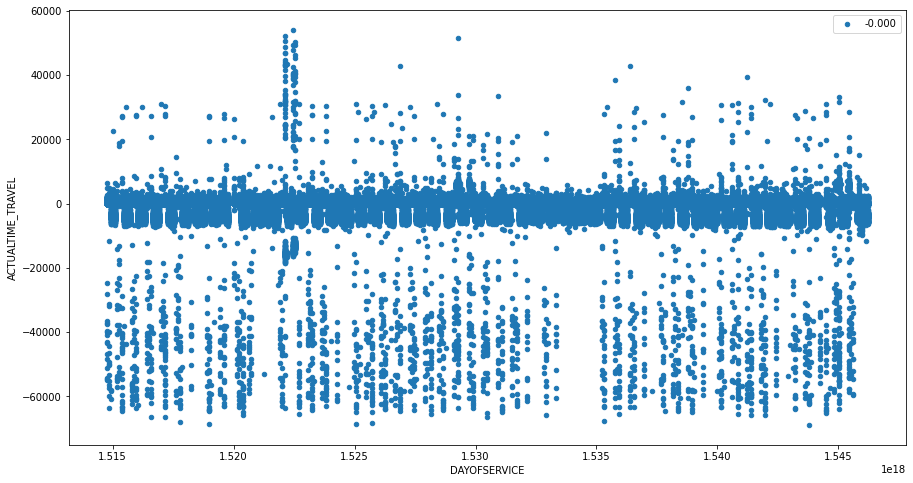

In [24]:
fig = plt.figure()
ax = fig.add_subplot
df_temp.plot(kind='scatter', x='DAYOFSERVICE', y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', 'DAYOFSERVICE']].corr().to_numpy()[0,1], figsize=(15, 8)) 

#### Plotting numerical features against target feature

In [25]:
# # Plot numerical features against target feature

# sns.set(style='white')

# # Calculating the correlation of all pairs of the numerical features
# corr = X_train[numerical_features].corr()

# # Generating a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# # Set up matplotlib figure
# f, ax = plt.subplots(figsize=(20,20))

# # Generating a custome color map
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
#             square=True, xticklabels=True, yticklabels=True,
#             linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
# plt.yticks(rotation = 0)
# plt.xticks(rotation = 90)

In [26]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    correlation_dt = df_temp[[column, 'ACTUALTIME_TRAVEL']].corr(method='pearson')
    print('\n',correlation_dt)


                    PLANNEDTIME_ARR  ACTUALTIME_TRAVEL
PLANNEDTIME_ARR            1.00000            0.03941
ACTUALTIME_TRAVEL          0.03941            1.00000

                    ACTUALTIME_ARR  ACTUALTIME_TRAVEL
ACTUALTIME_ARR           1.000000           0.040068
ACTUALTIME_TRAVEL        0.040068           1.000000

                    PLANNEDTIME_DEP  ACTUALTIME_TRAVEL
PLANNEDTIME_DEP            1.00000            0.03941
ACTUALTIME_TRAVEL          0.03941            1.00000

                    ACTUALTIME_DEP  ACTUALTIME_TRAVEL
ACTUALTIME_DEP           1.000000           0.040138
ACTUALTIME_TRAVEL        0.040138           1.000000

                    DWELLTIME  ACTUALTIME_TRAVEL
DWELLTIME           1.000000           0.036593
ACTUALTIME_TRAVEL   0.036593           1.000000

                     PLANNEDTIME_TRAVEL  ACTUALTIME_TRAVEL
PLANNEDTIME_TRAVEL              1.0000             0.9964
ACTUALTIME_TRAVEL               0.9964             1.0000


In [27]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    correlation_dt = df_temp[[column, 'ACTUALTIME_TRAVEL']].corr(method='spearman')
    print('\n',correlation_dt)


                    PLANNEDTIME_ARR  ACTUALTIME_TRAVEL
PLANNEDTIME_ARR           1.000000          -0.050591
ACTUALTIME_TRAVEL        -0.050591           1.000000

                    ACTUALTIME_ARR  ACTUALTIME_TRAVEL
ACTUALTIME_ARR           1.000000          -0.048827
ACTUALTIME_TRAVEL       -0.048827           1.000000

                    PLANNEDTIME_DEP  ACTUALTIME_TRAVEL
PLANNEDTIME_DEP           1.000000          -0.050591
ACTUALTIME_TRAVEL        -0.050591           1.000000

                    ACTUALTIME_DEP  ACTUALTIME_TRAVEL
ACTUALTIME_DEP           1.000000          -0.048472
ACTUALTIME_TRAVEL       -0.048472           1.000000

                    DWELLTIME  ACTUALTIME_TRAVEL
DWELLTIME           1.000000           0.335162
ACTUALTIME_TRAVEL   0.335162           1.000000

                     PLANNEDTIME_TRAVEL  ACTUALTIME_TRAVEL
PLANNEDTIME_TRAVEL            1.000000           0.772725
ACTUALTIME_TRAVEL             0.772725           1.000000


<Figure size 432x288 with 0 Axes>

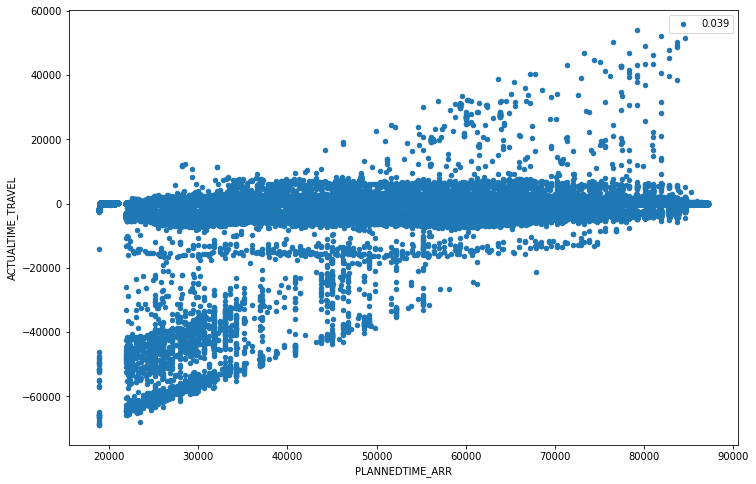

<Figure size 432x288 with 0 Axes>

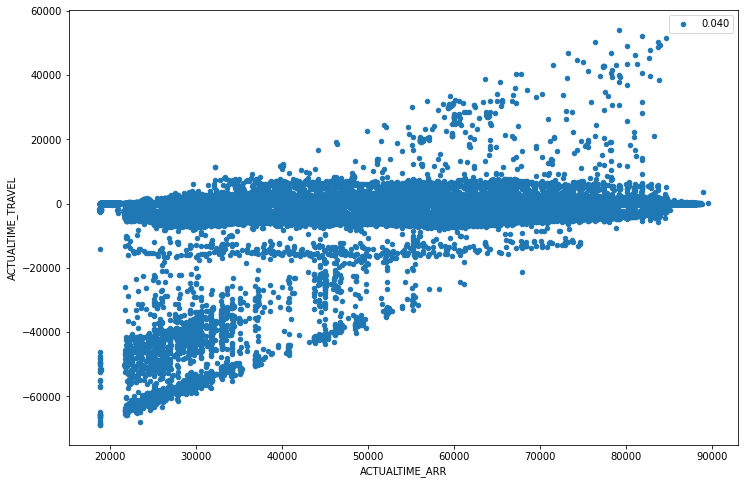

<Figure size 432x288 with 0 Axes>

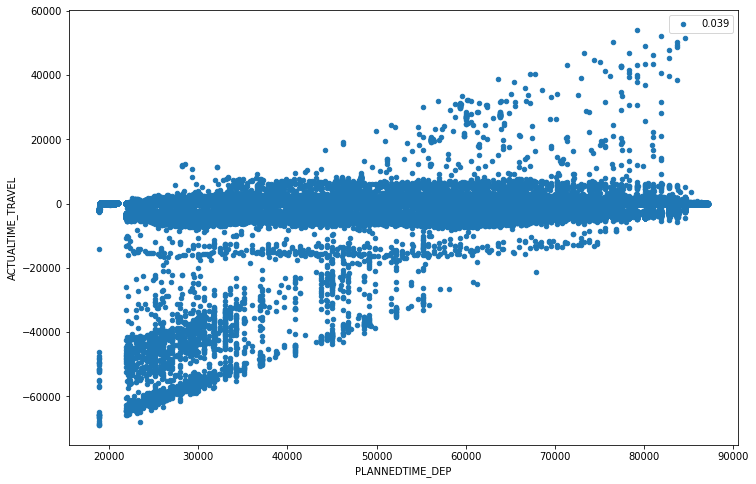

<Figure size 432x288 with 0 Axes>

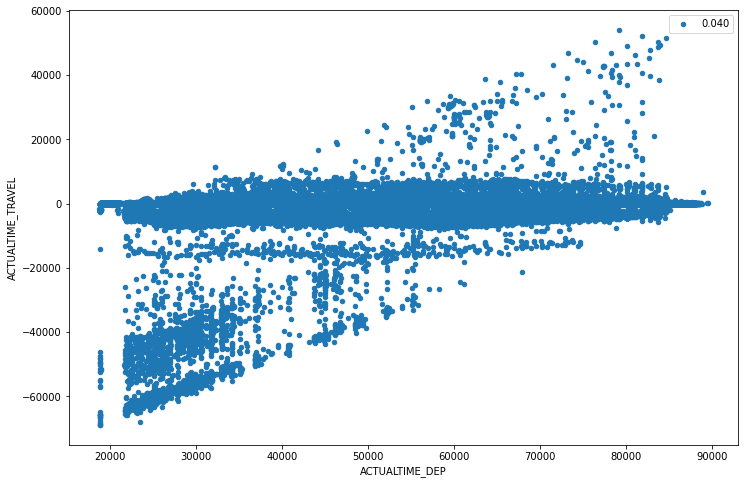

<Figure size 432x288 with 0 Axes>

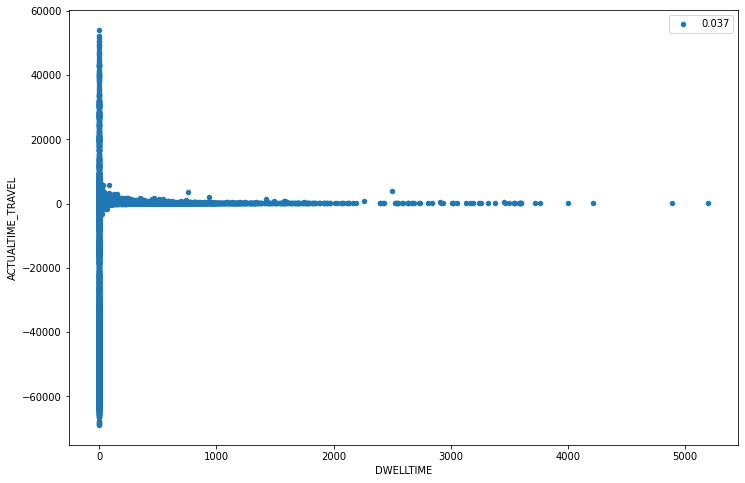

<Figure size 432x288 with 0 Axes>

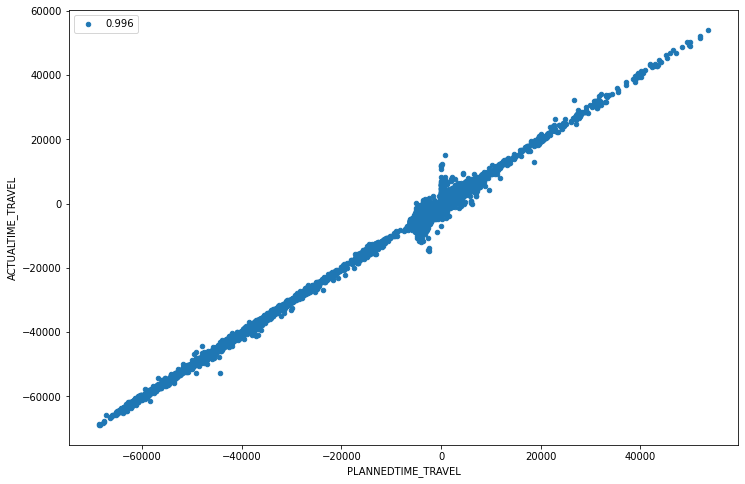

In [28]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    fig = plt.figure()
    ax = fig.add_subplot
    df_temp.plot(kind='scatter', x=column, y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', column]].corr(method='pearson').to_numpy()[0,1], figsize=(12, 8)) 

<Figure size 432x288 with 0 Axes>

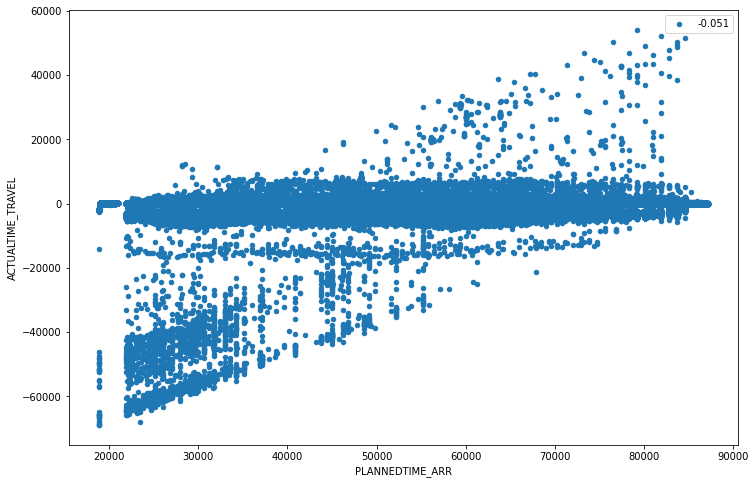

<Figure size 432x288 with 0 Axes>

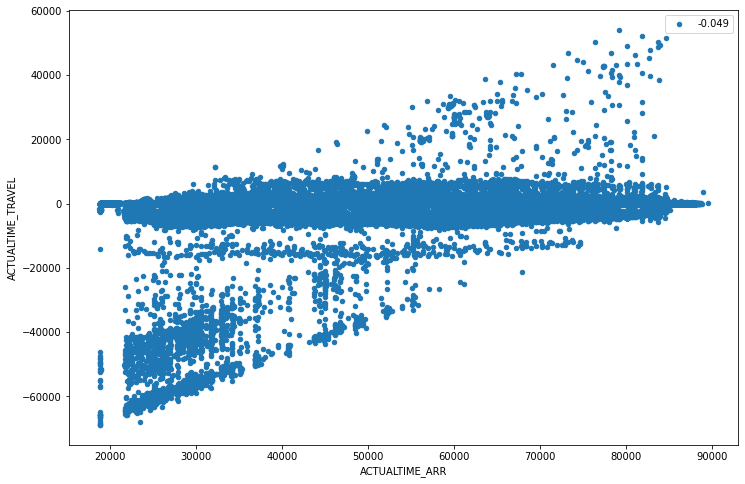

<Figure size 432x288 with 0 Axes>

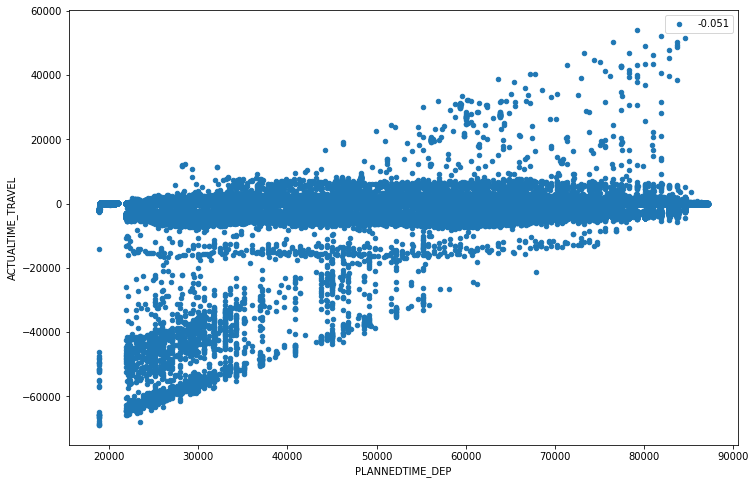

<Figure size 432x288 with 0 Axes>

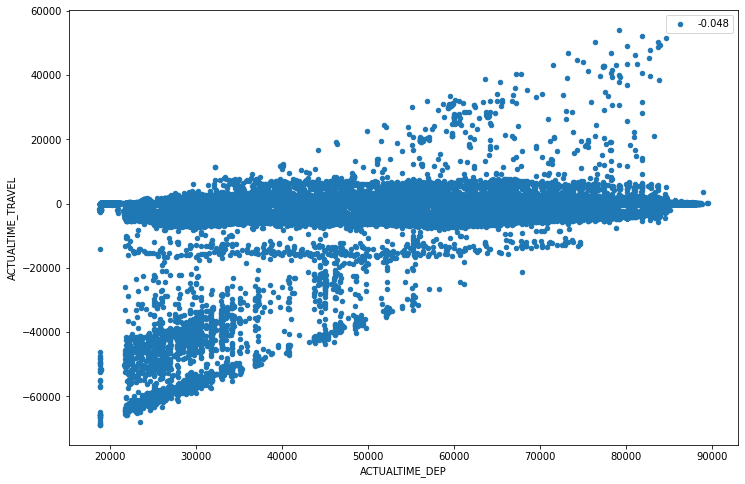

<Figure size 432x288 with 0 Axes>

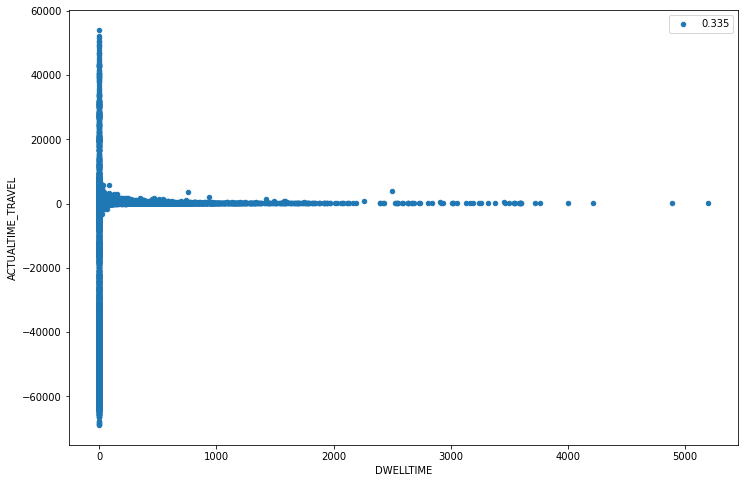

<Figure size 432x288 with 0 Axes>

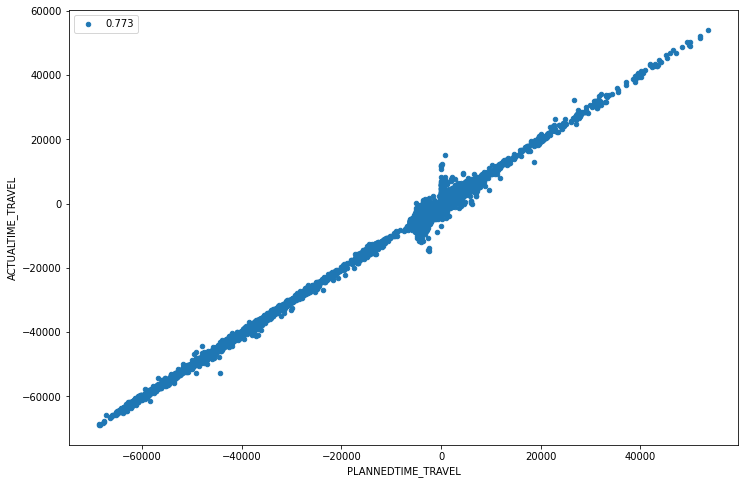

In [29]:
for column in numerical_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    fig = plt.figure()
    ax = fig.add_subplot
    df_temp.plot(kind='scatter', x=column, y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', column]].corr(method='spearman').to_numpy()[0,1], figsize=(12, 8)) 

#### Plotting categorical features against target feature

In [106]:
# Finding the average between some categorical
year_features = ['DAYOFWEEK', 'IS_HOLIDAY', 'IS_WEEKDAY', 'MONTHOFSERVICE']

# For each unique value feature, calculating the average for the actualtime_travel
df_temp = pd.concat([X_train, y_train], axis=1)
x = df_temp[df_temp['DAYOFWEEK']=='Monday']['ACTUALTIME_TRAVEL'].tolist()
y = len(x)
for days in df_temp['DAYOFWEEK'].unique():
    print(days)

Sunday
Monday
Tuesday
Thursday
Wednesday
Friday
Saturday


In [109]:
for feature in year_features:
    print(feature)
    df_temp = pd.concat([X_train, y_train], axis=1)
    unique = df_temp[feature].unique()
    for value in unique:
        print(f'{value} \n')
        list_values = df_temp[df_temp[feature]== value]['ACTUALTIME_TRAVEL'].tolist()
        length_list = len(list_values)
        average =  sum(list_values)/length_list
        print(f'Sum of values / list of values: \n {sum(list_values)} / {length_list}')
        print(f'Average ACTUALTIME_TRAVEL: {average}, \n')

DAYOFWEEK
Sunday 

Sum of values / list of values: 
 -2410850 / 300892
Average ACTUALTIME_TRAVEL: -8.012343299256877, 

Monday 

Sum of values / list of values: 
 -10315495 / 471287
Average ACTUALTIME_TRAVEL: -21.887926040820137, 

Tuesday 

Sum of values / list of values: 
 -8531411 / 494012
Average ACTUALTIME_TRAVEL: -17.26964324753245, 

Thursday 

Sum of values / list of values: 
 -7674028 / 471528
Average ACTUALTIME_TRAVEL: -16.274808707012095, 

Wednesday 

Sum of values / list of values: 
 -8651564 / 484736
Average ACTUALTIME_TRAVEL: -17.847991484024295, 

Friday 

Sum of values / list of values: 
 -8073492 / 474130
Average ACTUALTIME_TRAVEL: -17.02801341404256, 

Saturday 

Sum of values / list of values: 
 -5597360 / 346865
Average ACTUALTIME_TRAVEL: -16.136998544102173, 

IS_HOLIDAY
0 

Sum of values / list of values: 
 -50065780 / 2989166
Average ACTUALTIME_TRAVEL: -16.74907984367546, 

1 

Sum of values / list of values: 
 -1188420 / 54284
Average ACTUALTIME_TRAVEL: -21.892

In [ ]:
# 